# Springboard Apps project - Tier 3 - Complete

Welcome to the Apps project! To give you a taste of your future career, we're going to walk through exactly the kind of notebook that you'd write as a data scientist. In the process, we'll be sure to signpost the general framework for our investigation - the Data Science Pipeline - as well as give reasons for why we're doing what we're doing. We're also going to apply some of the skills and knowledge you've built up in the previous unit when reading Professor Spiegelhalter's *The Art of Statistics* (hereinafter *AoS*). 

So let's get cracking!

**Brief**

Did Apple Store apps receive better reviews than Google Play apps?

## Stages of the project

1. Sourcing and loading 
    * Load the two datasets
    * Pick the columns that we are going to work with 
    * Subsetting the data on this basis 
 
 
2. Cleaning, transforming and visualizing
    * Check the data types and fix them
    * Add a `platform` column to both the `Apple` and the `Google` dataframes
    * Changing the column names to prepare for a join 
    * Join the two data sets
    * Eliminate the `NaN` values
    * Filter only those apps that have been reviewed at least once
    * Summarize the data visually and analytically (by the column `platform`)  
  
  
3. Modelling 
    * Hypothesis formulation
    * Getting the distribution of the data
    * Permutation test 


4. Evaluating and concluding 
    * What is our conclusion?
    * What is our decision?
    * Other models we could have used. 
    

## Importing the libraries

In this case we are going to import pandas, numpy, scipy, random and matplotlib.pyplot

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# scipi is a library for statistical tests and visualizations 
from scipy import stats
# random enables us to generate random numbers
import random
from tqdm import tqdm

## Stage 1 -  Sourcing and loading data

### 1a. Source and load the data
Let's download the data from Kaggle. Kaggle is a fantastic resource: a kind of social medium for data scientists, it boasts projects, datasets and news on the freshest libraries and technologies all in one place. The data from the Apple Store can be found [here](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps) and the data from Google Store can be found [here](https://www.kaggle.com/lava18/google-play-store-apps).
Download the datasets and save them in your working directory.

In [8]:
google = pd.read_csv('googleplaystore.csv')
google.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [9]:
apple = pd.read_csv('AppleStore.csv', index_col=0)
apple.head(3)

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1


### 1b. Pick the columns we'll work with

From the documentation of these datasets, we can infer that the most appropriate columns to answer the brief are:

1. Google:
    * `Category` # Do we need this?
    * `Rating`
    * `Reviews`
    * `Price` (maybe)
2. Apple:    
    * `prime_genre` # Do we need this?
    * `user_rating` 
    * `rating_count_tot`
    * `price` (maybe)

### 1c. Subsetting accordingly

Let's select only those columns that we want to work with from both datasets. We'll overwrite the subsets in the original variables.

In [12]:
# Subset our DataFrame object Google by selecting just the variables ['Category', 'Rating', 'Reviews', 'Price']
google = google.loc[:,['Category', 'Rating', 'Reviews', 'Price']]

# Check the first three entries
google.head(3)

,Category,Rating,Reviews,Price
0,ART_AND_DESIGN,4.1,159,0
1,ART_AND_DESIGN,3.9,967,0
2,ART_AND_DESIGN,4.7,87510,0


In [13]:
# Do the same with our Apple object, selecting just the variables ['prime_genre', 'user_rating', 'rating_count_tot', 'price']
apple = apple.loc[:,['prime_genre', 'user_rating', 'rating_count_tot', 'price']]

# Let's check the first three entries
apple.head(3)

,prime_genre,user_rating,rating_count_tot,price
1,Games,4.0,21292,3.99
2,Productivity,4.0,161065,0.00
3,Weather,3.5,188583,0.00


## Stage 2 -  Cleaning, transforming and visualizing

### 2a. Check the data types for both Apple and Google, and fix them

Types are crucial for data science in Python. Let's determine whether the variables we selected in the previous section belong to the types they should do, or whether there are any errors here. 

In [16]:
# Using the dtypes feature of pandas DataFrame objects, check out the data types within our Apple dataframe.
# Are they what you expect?
apple.dtypes

prime_genre          object
user_rating         float64
rating_count_tot      int64
price               float64
dtype: object

This is looking healthy. But what about our Google data frame?

In [18]:
# Using the same dtypes feature, check out the data types of our Google dataframe. 
google.dtypes

Category     object
Rating      float64
Reviews      object
Price        object
dtype: object

Weird. The data type for the column 'Price' is 'object', not a numeric data type like a float or an integer. Let's investigate the unique values of this column. 

In [20]:
# Use the unique() pandas method on the Price column to check its unique values. 
google.Price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', 'Everyone', '$1.20', '$1.04'], dtype=object)

Aha! Fascinating. There are actually two issues here. 

- Firstly, there's a price called `Everyone`. That is a massive mistake! 
- Secondly, there are dollar symbols everywhere! 


Let's address the first issue first. Let's check the datapoints that have the price value `Everyone`

In [22]:
# Let's check which data points have the value 'Everyone' for the 'Price' column by subsetting our Google dataframe.

# Subset the Google dataframe on the price column. 
# To be sure: you want to pick out just those rows whose value for the 'Price' column is just 'Everyone'. 
google[google.Price == 'Everyone']

,Category,Rating,Reviews,Price
10472,1.9,19.0,3.0M,Everyone


Thankfully, it's just one row. We've gotta get rid of it. 

In [24]:
# Let's eliminate that row. 

# Subset our Google dataframe to pick out just those rows whose value for the 'Price' column is NOT 'Everyone'. 
# Reassign that subset to the Google variable. 
# You can do this in two lines or one. Your choice! 
google = google[google.Price != 'Everyone']

# Check again the unique values of Google
google.Price.unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

Our second problem remains: I'm seeing dollar symbols when I close my eyes! (And not in a good way). 

This is a problem because Python actually considers these values strings. So we can't do mathematical and statistical operations on them until we've made them into numbers. 

In [26]:
# Let's create a variable called nosymb.
# This variable will take the Price column of Google and apply the str.replace() method. 
google.Price = google.Price.str.replace('$','')
google.Price = google.Price.astype('float')

Now let's check the data types for our Google dataframe again, to verify that the 'Price' column really is numeric now.

In [28]:
# Use the function dtypes. 
google.dtypes

Category     object
Rating      float64
Reviews      object
Price       float64
dtype: object

Notice that the column `Reviews` is still an object column. We actually need this column to be a numeric column, too. 

In [30]:
# Convert the 'Reviews' column to a numeric data type. 
google.Reviews = google.Reviews.astype('int')

In [31]:
# Let's check the data types of Google again
google.dtypes

Category     object
Rating      float64
Reviews       int32
Price       float64
dtype: object

### 2b. Add a `platform` column to both the `Apple` and the `Google` dataframes
Let's add a new column to both dataframe objects called `platform`: all of its values in the Google dataframe will be just 'google', and all of its values for the Apple dataframe will be just 'apple'. 

The reason we're making this column is so that we can ultimately join our Apple and Google data together, and actually test out some hypotheses to solve the problem in our brief. 

In [42]:
# Create a column called 'platform' in both the Apple and Google dataframes. 
# Add the value 'apple' and the value 'google' as appropriate. 
google.loc[:,'platform'] = 'google'
apple.loc[:,'platform'] = 'apple'

### 2c. Changing the column names to prepare for our join of the two datasets 
Since the easiest way to join two datasets is if they have both:
- the same number of columns
- the same column names
we need to rename the columns of `Apple` so that they're the same as the ones of `Google`, or vice versa.

In this case, we're going to change the `Apple` columns names to the names of the `Google` columns. 

This is an important step to unify the two datasets!

In [45]:
# Use the rename() DataFrame method to change the columns names. 
apple.rename(columns = {
    'prime_genre':'Category',
    'user_rating':'Rating',
    'rating_count_tot':'Reviews',
    'price':'Price',
}, inplace=True)

### 2d. Join the two datasets 
Let's combine the two datasets into a single data frame called `df`.

In [48]:
# Let's use the append() method to append Apple to Google. 
df = pd.concat([google,apple])

# Using the sample() method with the number 12 passed to it, check 12 random points of your dataset.
df.sample(12)

,Category,Rating,Reviews,Price,platform
10326,LIFESTYLE,5.0,19,0.00,google
1651,Travel,4.0,1155,4.99,apple
9375,SPORTS,3.8,35746,0.00,google
9209,HEALTH_AND_FITNESS,NaN,0,0.00,google
7468,Photo & Video,5.0,7,1.99,apple
7763,TOOLS,4.2,7063,0.00,google
270,Music,4.0,135744,0.00,apple
7664,Food & Drink,4.5,2,0.00,apple
2503,Games,4.5,1072,1.99,apple
8407,GAME,4.3,331692,0.00,google


### 2e. Eliminate the NaN values

As you can see there are some `NaN` values. We want to eliminate all these `NaN` values from the table.

In [51]:
# Lets check first the dimesions of df before droping `NaN` values. Use the .shape feature. 
print('shape before drop:', df.shape)

# Use the dropna() method to eliminate all the NaN values, and overwrite the same dataframe with the result. 
df.dropna(inplace=True)

# Check the new dimesions of our dataframe. 
print('shape after drop:', df.shape)

shape before drop: (18037, 5)
shape after drop: (16563, 5)


### 2f. Filter the data so that we only see whose apps that have been reviewed at least once

Apps that haven't been reviewed yet can't help us solve our brief. 

So let's check to see if any apps have no reviews at all. 

In [54]:
# Subset your df to pick out just those rows whose value for 'Reviews' is equal to 0. 
# Do a count() on the result. 
df[df.Reviews == 0].shape[0]

929

929 apps do not have reviews, we need to eliminate these points!

In [57]:
# Eliminate the points that have 0 reviews.
df = df[df.Reviews != 0]

### 2g. Summarize the data visually and analytically (by the column `platform`)

What we need to solve our brief is a summary of the `Rating` column, but separated by the different platforms.

In [61]:
# To summarize analytically, let's use the groupby() method on our df.
df.groupby('platform').mean(numeric_only=True)

,Rating,Reviews,Price
platform,,,
apple,4.049697,14803.805520,1.821977
google,4.191757,514049.836536,0.960928


Interesting! Our means of 4.049697 and 4.191757 don't **seem** all that different! Perhaps we've solved our brief already: there's no significant difference between Google Play app reviews and Apple Store app reviews. We have an ***observed difference*** here: which is simply (4.191757 - 4.049697) = 0.14206. This is just the actual difference that we observed between the mean rating for apps from Google Play, and the mean rating for apps from the Apple Store. Let's look at how we're going to use this observed difference to solve our problem using a statistical test. 

**Outline of our method:**
1. We'll assume that platform (i.e, whether the app was Google or Apple) really doesn’t impact on ratings. 


2. Given this assumption, we should actually be able to get a difference in mean rating for Apple apps and mean rating for Google apps that's pretty similar to the one we actually got (0.14206) just by: 
a. shuffling the ratings column, 
b. keeping the platform column the same,
c. calculating the difference between the mean rating for Apple and the mean rating for Google. 


3. We can make the shuffle more useful by doing it many times, each time calculating the mean rating for Apple apps and the mean rating for Google apps, and the difference between these means. 


4. We can then take the mean of all these differences, and this will be called our permutation difference. This permutation difference will be great indicator of what the difference would be if our initial assumption were true and platform really doesn’t impact on ratings. 


5. Now we do a comparison. If the observed difference looks just like the permutation difference, then we stick with the claim that actually, platform doesn’t impact on ratings. If instead, however, the permutation difference differs significantly from the observed difference, we'll conclude: something's going on; the platform does in fact impact on ratings. 


6. As for what the definition of *significantly* is, we'll get to that. But there’s a brief summary of what we're going to do. Exciting!

If you want to look more deeply at the statistics behind this project, check out [this resource](https://www.springboard.com/archeio/download/4ea4d453b0b84014bcef287c50f47f00/).

Let's also get a **visual summary** of the `Rating` column, separated by the different platforms. 

A good tool to use here is the boxplot!

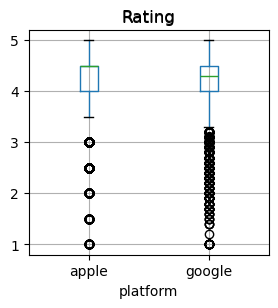

In [65]:
# Call the boxplot() method on our df.
df.boxplot(by='platform', column = ['Rating'], figsize=(3,3))
plt.suptitle('Rating',y=0.966)
plt.show()

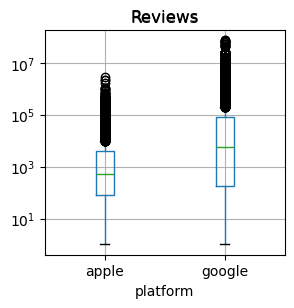

In [67]:
df.boxplot(by='platform', column = ['Reviews'], figsize=(3,3))
plt.suptitle('Reviews',y=0.966)
plt.yscale('log')
plt.show()

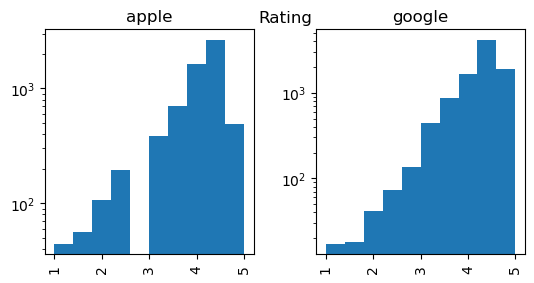

In [69]:
df.hist(by='platform', column = ['Rating'], figsize=(6,3), log=True)
plt.suptitle('Rating',y=0.966)
plt.show()

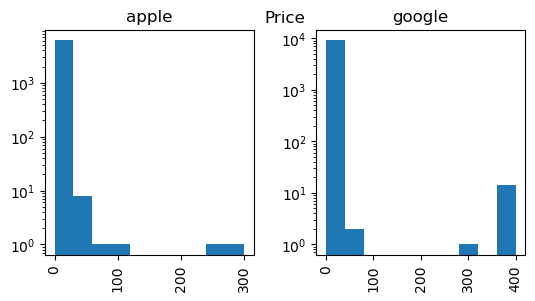

In [71]:
df.hist(by='platform', column = ['Price'], figsize=(6,3), log=True)
plt.suptitle('Price',y=0.966)
plt.show()

Here we see the same information as in the analytical summary, but with a boxplot. Can you see how the boxplot is working here? If you need to revise your boxplots, check out this this [link](https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps). 

## Stage 3 - Modelling

### 3a. Hypothesis formulation

Our **Null hypothesis** is just:

**H<sub>null</sub>**: the observed difference in the mean rating of Apple Store and Google Play apps is due to chance (and thus not due to the platform).

The more interesting hypothesis is called the **Alternate hypothesis**:

**H<sub>alternative</sub>**: the observed difference in the average ratings of apple and google users is not due to chance (and is actually due to platform)

We're also going to pick a **significance level** of 0.05. 

### 3b. Getting the distribution of the data
Now that the hypotheses and significance level are defined, we can select a statistical test to determine which hypothesis to accept. 

There are many different statistical tests, all with different assumptions. You'll generate an excellent judgement about when to use which statistical tests over the Data Science Career Track course. But in general, one of the most important things to determine is the **distribution of the data**.   

In [77]:
# Create a subset of the column 'Rating' by the different platforms.
# Call the subsets 'apple' and 'google' 
apple = df[df.platform == 'apple'].Rating
google = df[df.platform == 'google'].Rating

In [79]:
# Using the stats.normaltest() method, get an indication of whether the apple data are normally distributed
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest
# Save the result in a variable called apple_normal, and print it out
apple_normal = stats.normaltest(apple)
print(apple_normal)

NormaltestResult(statistic=1778.9974234584017, pvalue=0.0)


In [81]:
# Do the same with the google data. 
google_normal = stats.normaltest(google)
print(google_normal)

NormaltestResult(statistic=3678.6157187516856, pvalue=0.0)


Since the null hypothesis of the normaltest() is that the data are normally distributed, the lower the p-value in the result of this test, the more likely the data are to be non-normal. 

Since the p-values is 0 for both tests, regardless of what we pick for the significance level, our conclusion is that the data are not normally distributed. 

We can actually also check out the distribution of the data visually with a histogram. A normal distribution has the following visual characteristics:
    - symmetric
    - unimodal (one hump)
As well as a roughly identical mean, median and mode. 

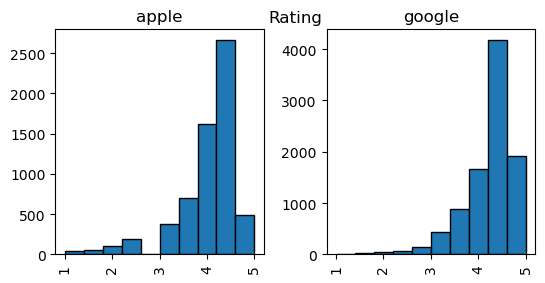

In [84]:
# Create a histogram of the apple reviews distribution
df.hist(by='platform', column = ['Rating'], figsize=(6,3), log=False, edgecolor='k')
plt.suptitle('Rating',y=0.966)
plt.show()

### 3c. Permutation test
Since the data aren't normally distributed, we're using a *non-parametric* test here. This is simply a label for statistical tests used when the data aren't normally distributed. These tests are extraordinarily powerful due to how few assumptions we need to make.  

Check out more about permutations [here.](http://rasbt.github.io/mlxtend/user_guide/evaluate/permutation_test/)

In [87]:
# Create a column called `Permutation1`, and assign to it the result of permuting (shuffling) the Rating column
# This assignment will use our numpy object's random.permutation() method
df.loc[:,'Permutation1'] = np.random.permutation(df.Rating)

# Call the describe() method on our permutation grouped by 'platform'. 
df.groupby('platform').describe().T.loc[['Rating','Permutation1']]

platform                  apple       google
Rating       count  6268.000000  9366.000000
             mean      4.049697     4.191757
             std       0.726943     0.515219
             min       1.000000     1.000000
             25%       4.000000     4.000000
             50%       4.500000     4.300000
             75%       4.500000     4.500000
             max       5.000000     5.000000
Permutation1 count  6268.000000  9366.000000
             mean      4.135689     4.134209
             std       0.614859     0.611706
             min       1.000000     1.000000
             25%       4.000000     4.000000
             50%       4.300000     4.300000
             75%       4.500000     4.500000
             max       5.000000     5.000000

In [89]:
# Lets compare with the previous analytical summary:
print('observed difference of mean rating:\t\t', 
      df[df.platform=='google'].Rating.mean() - df[df.platform=='apple'].Rating.mean(),
      '\nrandom permutation difference of mean rating:\t', 4.136451 - 4.132339)

observed difference of mean rating:		 0.1420605474512291 
random permutation difference of mean rating:	 0.0041120000000001156


In [ ]:
# The difference in the means for Permutation1 (0.001103) now looks hugely different to our observed difference of 0.14206. 
# It's sure starting to look like our observed difference is significant, and that the Null is false; platform does impact on ratings
# But to be sure, let's create 10,000 permutations, calculate the mean ratings for Google and Apple apps and the difference between these for each one, and then take the average of all of these differences.
# Let's create a vector with the differences - that will be the distibution of the Null.

# First, make a list called difference.
difference = np.empty(10000)

# Now make a for loop that does the following 10,000 times:
# 1. makes a permutation of the 'Rating' as you did above
# 2. calculates the difference in the mean rating for apple and the mean rating for google. 
for i in tqdm(range(10000)):
    df.loc[:,'Permutation1'] = np.random.permutation(df.Rating)
    means = df[['Permutation1','platform']].groupby('platform').mean().values
    difference[i] = means[0]-means[1]

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Dev\AppData\Local\Temp\ipykernel_16608\2304081815.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  difference[i] = means[0]-means[1]
C:\Users\Dev\AppData\Local\Temp\ipykernel_16608\2304081815.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  difference[i] = means[0]-means[1]
C:\Users\Dev\AppData\Local\Temp\ipykernel_16608\2304081815.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  difference[i] = means[0]

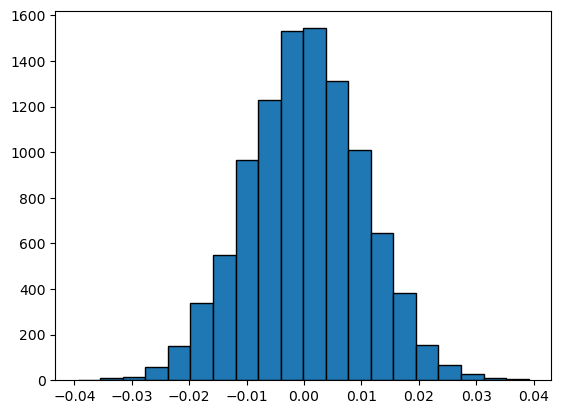

In [93]:
# Make a variable called 'histo', and assign to it the result of plotting a histogram of the difference list. 
plt.hist(difference, bins=20, edgecolor='k')
plt.show()

In [94]:
# Now make a variable called obs_difference, and assign it the result of the mean of our 'apple' variable and the mean of our 'google variable'
obs_difference = abs(df[df.platform=='google'].Rating.mean() - df[df.platform=='apple'].Rating.mean())

# Print out this value; it should be 0.1420605474512291. 
print(obs_difference)

0.1420605474512291


## Stage 4 -  Evaluating and concluding
### 4a. What is our conclusion?

In [98]:
'''
What do we know? 

Recall: The p-value of our observed data is just the proportion of the data given the null that's at least as extreme as that observed data.

As a result, we're going to count how many of the differences in our difference list are at least as extreme as our observed difference.

If less than or equal to 5% of them are, then we will reject the Null. 
'''
(np.abs(difference) >= obs_difference).sum()

0

### 4b. What is our decision?
So actually, zero differences are at least as extreme as our observed difference!

So the p-value of our observed data is 0. 

It doesn't matter which significance level we pick; our observed data is statistically significant, and we reject the Null.

We conclude that platform does impact on ratings. Specifically, we should advise our client to integrate **only Google Play** into their operating system interface. 

### 4c. Other statistical tests, and next steps
The test we used here is the Permutation test. This was appropriate because our data were not normally distributed! 

As we've seen in Professor Spiegelhalter's book, there are actually many different statistical tests, all with different assumptions. How many of these different statistical tests can you remember? How much do you remember about what the appropriate conditions are under which to use them? 

Make a note of your answers to these questions, and discuss them with your mentor at your next call. 
